# Init

In [1]:
! pip install qrcode -q
! pip install insightface -q
! pip install onnxruntime -q

In [2]:
import requests  
import json  
import qrcode

In [13]:
gen_image = 'gen.png'
qr_image = 'qr.png'
output_image = 'output.png'
webcam_image = 'webcam.jpeg'

# Step 1

In [4]:

  
url =  "https://stablediffusionapi.com/api/v4/dreambooth"  
  
payload = json.dumps({  
    "key":  "7v70nMZ61AbixLzjyBXGZEKIPyDimkwhajobxeVD1vZRE3kLDyNVbQypfkR0",  
    "model_id":  "realistic-vision-v51",  
    "prompt":  "A girl, standing in the future world, hyper realistic , medium shot, half body shot, illustration, fancy background, epic background, epic, intricate, hyper detailed, art station, concept art, smooth, sharp focus, ray tracing, colorful",  
    "negative_prompt":  "",  
    "width":  "512",  
    "height":  "512",  
    "samples":  "1",  
    "num_inference_steps":  "30",  
    "safety_checker":  "no",  
    "enhance_prompt":  "yes",  
    "seed":  None,  
    "guidance_scale":  7.5,  
    "multi_lingual":  "no",  
    "panorama":  "no",  
    "self_attention":  "no",  
    "upscale":  "no",  
    "embeddings":  "embeddings_model_id",  
    "lora":  "lora_model_id",  
    "webhook":  None,  
    "track_id":  None  
})  
  
headers =  {  
'Content-Type':  'application/json'  
}  

response = requests.request("POST", url, headers=headers, data=payload)  


In [5]:
response.text

'{"status":"success","generationTime":3.2083237171173096,"id":35596331,"output":["https:\\/\\/cdn2.stablediffusionapi.com\\/generations\\/0-4c997b46-19d3-41f4-8501-0a0af00b477f.png"],"webhook_status":"","meta":{"prompt":" A girl, standing in the future world, hyper realistic , medium shot, half body shot, illustration, fancy background, epic background, epic, intricate, hyper detailed, art station, concept art, smooth, sharp focus, ray tracing, colorful hyperrealistic, full body, detailed clothing, highly detailed, cinematic lighting, stunningly beautiful, intricate, sharp focus, f\\/1. 8, 85mm, (centered image composition), (professionally color graded), ((bright soft diffused light)), volumetric fog, trending on instagram, trending on tumblr, HDR 4K, 8K","model_id":"realistic-vision-v51","negative_prompt":"(child:1.5), ((((underage)))), ((((child)))), (((kid))), (((preteen))), (teen:1.5) ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs

In [6]:
url = json.loads(response.text)['output'][0]

url

'https://cdn2.stablediffusionapi.com/generations/0-4c997b46-19d3-41f4-8501-0a0af00b477f.png'

In [7]:
response = requests.get(url, stream=True)
response.raise_for_status()

# Open a local file with wb (write binary) permission.
with open(gen_image, 'wb') as out_file:
    # Write the content of the image to the file.
    for chunk in response.iter_content(8192):
        out_file.write(chunk)

# Step 2: Swap face

In [8]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
from PIL import Image
import matplotlib.pyplot as plt

## 2-1 Detect face

/opt/conda/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/jovyan/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/jovyan/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/jovyan/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/jovyan/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/jovyan/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

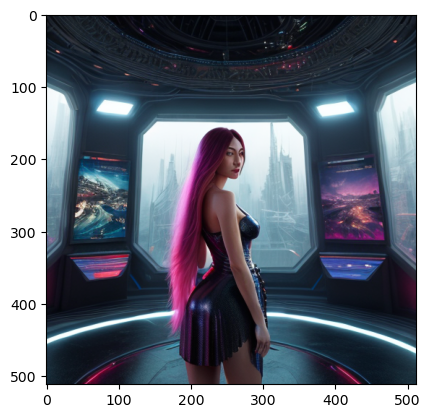

In [9]:
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

# Open an image file
image_path = gen_image
with Image.open(image_path) as image:
    bg_img = np.array(image)

plt.imshow(bg_img)

/opt/conda/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


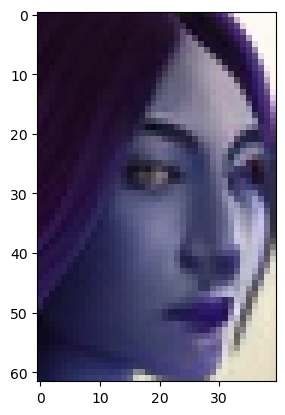

In [10]:
face_on_bg = app.get(bg_img)[0]

bbox = face_on_bg['bbox']
bbox = [int(b) for b in bbox]
plt.imshow(bg_img[bbox[1]:bbox[3],
                  bbox[0]:bbox[2],
                  ::-1])

## 2-2 Swap face

In [11]:
swapper = insightface.model_zoo.get_model('inswapper_128.onnx',
                                          download=False,
                                          download_zip=False)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
inswapper-shape: [1, 3, 128, 128]


In [14]:
# Open an image file
image_path = webcam_image
with Image.open(image_path) as image:
    face_from_webcam = np.array(image)
    
face_from_webcam = app.get(face_from_webcam)[0]

In [15]:
output = swapper.get(bg_img, face_on_bg, face_from_webcam, paste_back=True)

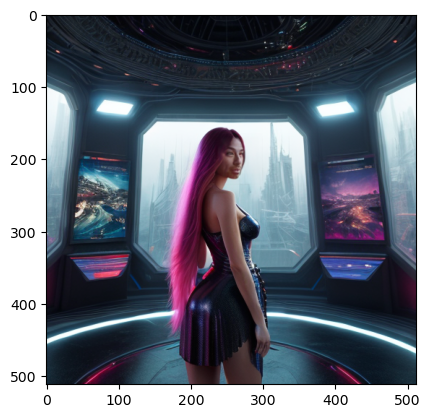

In [16]:
output_filename = output_image

# Convert ndarray to an Image object
image = Image.fromarray(output)

# Save the image
image.save(output_filename)


plt.imshow(output)

# Step 3

In [17]:
url = "http://140.119.112.78:8823/lab/tree/work/CID/" + output_image
# url = "https://b42a.myqnapcloud.com/share.cgi?tunnel_agent_id=60cb61cda1c19d7d2f5c0f5a&func=get_thumb&ssid=a92b1c85a77840e1858c26b61b63bbd2&access_token=2.wX3yAxbnXO4asGBHPDpLfV6oY82Tfq2KssYASQPA.1692580720&fid=a92b1c85a77840e1858c26b61b63bbd2&path=%2F&size=640&name={}&cacheSlayer=766567.895074163".format(output_filename)
# url = "https://www.myqnapcloud.com/smartshare/72ff17jlj1n32r2t9x4w1b8y_a60e1h08i23529s2082v83x51a86deh9"

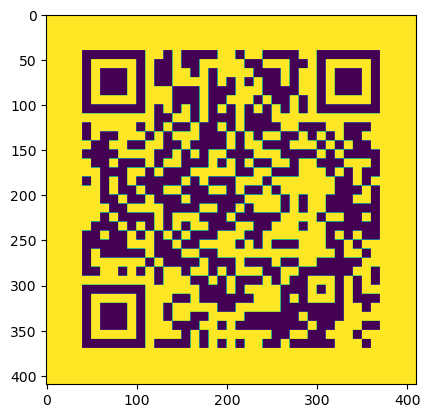

In [18]:

qr_img = qrcode.make(url)
plt.imshow(qr_img)